<h1>Sentiment classification project</h1>
<br>
Li-Hsin Chang<br>
Akseli Leino<br>
Pham Huynh Uyen Phuong<br>
Amanda Tursi<br>

<h1>Milestone 1</h1><br>
There are a number of ready-made English sentiment datasets in the wild. For example here are mentioned several, and that is just one of a number of similar lists. Summarize the existing datasets in terms of what is available, and how these datasets differ from each other. Pick two interesting ones from different domains and train a sentiment classifier on them. Report results both in terms of accuracy/precision/recall/F-score on the respective test set, as well as in terms of a small qualitative assessment of the mistakes made by the classifier.

<h2>Sentiment classification datasets</h2>
<br>
We choose two datasets for this project, the IMDB dataset and the Twitter dataset (i.e. sentiment140).<br><br>
The IMDB dataset of movie reviews is available at http://ai.stanford.edu/~amaas/data/sentiment/. This dataset of 50,000 movie reviews was compiled by Andrew Maas. It was created in 2011 and is split into 25,000 reviews intended for training and another 25,000 for testing. Each set has 12,500 positive and the same amount of negative reviews.
<br><br>
Our second choice is the Twitter dataset which originated from Stanford University. 
http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
The data is in a CSV file with 6 features: the polarity of the tweet, the id of the tweet, the date of the tweet, the query, the user that tweeted and the text of the tweet.
<br><br>
In addition there are some other common datasets, which are not used in this project:<br>
<ul>
<li>Multidomain sentiment analysis dataset contains product reviews taken from Amazon.com from many product types. Some domains (as books,..) have hundreds of thousands of reviews. Reviews contain 1 to 5 stars that can be converted to binary labels if needed.</li>
<li>Stanford sentiment treebank:</li>
<li>Twitter US Airline Sentiment: The Twitter set is from February 2015 and contains tweets related to major US airlines. This is classified in positive, negative and neutral tweets.</li>
<li> The paper review dataset: This dataset contains sentiment labelled sentences derived from scientific paper reviews from an international conference on computing and informatics.</li>
</ul>

<h2>The IMDB dataset</h2>

In [1]:
import os
import random

# get the file names in each directory
imdb_train_neg = [f for f in os.listdir('aclImdb/train/neg')]
imdb_train_pos = [f for f in os.listdir('aclImdb/train/pos')]
imdb_test_neg = [f for f in os.listdir('aclImdb/test/neg')]
imdb_test_pos = [f for f in os.listdir('aclImdb/test/pos')]
print("File lists ready.")
def read(directory,path):
    texts = []
    for f in directory:
        f=os.path.join(path,f)
        with open(f, "rt") as inp_file:
            text = inp_file.readlines()
            assert len(text)==1
            texts.append(text[0].strip())
    return texts

# read all the files in each directory into a list
imdb_train_neg = read(imdb_train_neg,'aclImdb/train/neg')
imdb_train_pos = read(imdb_train_pos,'aclImdb/train/pos')
imdb_test_neg = read(imdb_test_neg,'aclImdb/test/neg')
imdb_test_pos = read(imdb_test_pos,'aclImdb/test/pos')

# add labels for texts
imdb_train_neg = [(text,-1) for text in imdb_train_neg]
imdb_train_pos = [(text,1) for text in imdb_train_pos]
imdb_test_neg = [(text,-1) for text in imdb_test_neg]
imdb_test_pos = [(text,1) for text in imdb_test_pos]

# shuffle the training set
imdb_train = imdb_train_neg + imdb_train_pos
random.shuffle(imdb_train)

imdb_train_texts = [text for text, label in imdb_train]
imdb_train_labels = [label for text, label in imdb_train]
#print(train_texts[:3])
print(imdb_train_labels[:20])

imdb_test = imdb_test_neg + imdb_test_pos
imdb_test_texts = [text for text, label in imdb_test]
imdb_test_labels = [label for text, label in imdb_test]

File lists ready.
[1, -1, -1, -1, 1, 1, 1, -1, -1, -1, 1, 1, 1, 1, 1, 1, -1, -1, 1, -1]


In [54]:
# How the IMDB data looks like

for text,label in zip(imdb_train_texts[:3],imdb_train_labels):
    print(text[:200],'...\t',label)
    print()

Sydney Lumet, although one of the oldest active directors, still got game! A few years ago he shot "Find me guilty", a proof to everyone that Vin Diesel can actually act, if he gets the opportunity an ...	 1

This movie is about a cop (Ching Wan Lau) trying to catch a super-clever thief (Ekin Cheng) who blackmails an insurance company headed by a Kelly Lin. Basically, whatever plans the cop tries the thief ...	 -1

This is a classic example of an increasing problem with films. Why is the background noise and the soundtrack dramatically louder than the dialogue? What sense does that make? This film isn't alone. M ...	 -1



<h2>The Twitter dataset</h2>

In [94]:
training = 'training.1600000.processed.noemoticon.csv'
test = 'testdata.manual.2009.06.14.csv'

import csv

def parse_tweets(filename):
    with open(filename, 'r',errors='ignore') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            assert len(row) == 6
            yield int(row[0]),row[-1]
                
tweets_train = [*parse_tweets(training)]
tweets_test = [*parse_tweets(test)]
tweets_test = [tweet for tweet in tweets_test if tweet[0]!=2]

import random
random.shuffle(tweets_train)

tweets_train_texts = [text for label, text in tweets_train]
tweets_train_labels = [label for label, text in tweets_train]
tweets_train_labels = [-1 if label==0 else 1 for label in tweets_train_labels]
tweets_test_texts = [text for label, text in tweets_test]
tweets_test_labels = [label for label, text in tweets_test]
tweets_test_labels = [-1 if label==0 else 1 for label in tweets_test_labels]

In [53]:
# How the Twitter data looks like

for text,label in zip(tweets_train_texts[:3],tweets_train_labels):
    print(text,label)
    print()

bought the grossest arizona tea tonight - yet still drinking it. graduated. tired as FUCK  -1

vc with @lcgretriever  1

@mollyblock Do you have U-verse? Trying to get it set up? I've had a great experience with AT&amp;T U-verse. Sorry you had a hard time!  -1



<h2>Vectorizing</h2>

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from eli5 import show_weights

space_tokenizer = lambda text: text.split()


# Featurization and vectorization
i_vectorizer = TfidfVectorizer(tokenizer=space_tokenizer, ngram_range=(1,2))
t_vectorizer = TfidfVectorizer(tokenizer=space_tokenizer, ngram_range=(1,2))

imdb_vectorizer = i_vectorizer.fit(imdb_train_texts)
imdb_train_X = imdb_vectorizer.transform(imdb_train_texts)
imdb_test_X = imdb_vectorizer.transform(imdb_test_texts)

tweets_vectorizer = t_vectorizer.fit(tweets_train_texts)
tweets_train_X = tweets_vectorizer.transform(tweets_train_texts)
tweets_test_X = tweets_vectorizer.transform(tweets_test_texts)

<h2>Training SVM classifier</h2>

In [11]:
%%time
# Training and prediction

imdb_classifier = LinearSVC(
    C=1.0,
    class_weight=None,
    max_iter=1000,
    loss='squared_hinge'
)
tweets_classifier = LinearSVC(
    C=1.0,
    class_weight=None,
    max_iter=1000,
    loss='squared_hinge'
)
imdb_classifier.fit(imdb_train_X, imdb_train_labels)
tweets_classifier.fit(tweets_train_X, tweets_train_labels)


CPU times: user 52.1 s, sys: 288 ms, total: 52.4 s
Wall time: 52.4 s


In [12]:
%%time
imdb_pred_labels = imdb_classifier.predict(imdb_test_X)
tweets_pred_labels = tweets_classifier.predict(tweets_test_X)

CPU times: user 68 ms, sys: 0 ns, total: 68 ms
Wall time: 65.5 ms


<h2>Results</h2>

In [13]:
# Evaluation and analysis
imdb_accuracy = accuracy_score(imdb_test_labels, imdb_pred_labels)
tweets_accuracy = accuracy_score(tweets_test_labels, tweets_pred_labels)

print('IMDB accuracy {:.2%}'.format(imdb_accuracy))
print('Tweets accuracy {:.2%}'.format(tweets_accuracy))

IMDB accuracy 89.72%
Tweets accuracy 82.45%


In [14]:
print("IMDB dataset results")
print(classification_report(imdb_test_labels, imdb_pred_labels))
print()
print("Tweet dataset results")
print(classification_report(tweets_test_labels, tweets_pred_labels))

IMDB dataset results
             precision    recall  f1-score   support

         -1       0.90      0.89      0.90     12500
          1       0.89      0.90      0.90     12500

avg / total       0.90      0.90      0.90     25000


Tweet dataset results
             precision    recall  f1-score   support

         -1       0.84      0.80      0.82       177
          1       0.81      0.85      0.83       182

avg / total       0.83      0.82      0.82       359



In [15]:
show_weights(imdb_classifier, vec=imdb_vectorizer)

In [16]:
show_weights(tweets_classifier, vec=tweets_vectorizer)

<h2>Misclassified instances</h2>

In [32]:
# print out misclassified results - imdb
# -1 = negative, 1= positive 

count = 0
positive_misclassified = 0
negative_misclassified = 0
for (text,gold_standard), prediction in zip(imdb_test, imdb_pred_labels):
    if gold_standard!=prediction:
        count += 1
        if gold_standard == 1:
            positive_misclassified += 1
        elif gold_standard == -1:
            negative_misclassified += 1
print('IMDB dataset')
print()
print('Number of misclassified instances:',count)
print('Percentage of misclassified negatives: {:.2f}%'.format(negative_misclassified/count*100))
print('Percentage of misclassified positives: {:.2f}%'.format(positive_misclassified/count*100))

Number of misclassified instances: 2571
Percentage of misclassified negatives: 52.12%
Percentage of misclassified positives: 47.88%


In [35]:
count = 0
for (text,gold_standard), prediction in zip(imdb_test, imdb_pred_labels):
    if gold_standard!=prediction:
        count += 1
        print('Prediction: %s'%(imdb_pred_labels[prediction]))
        print(text)
        print()
        if count>2:
            break

Prediction: -1
Carlos is perhaps not the most original comic, but the first series was amusing, his forthright comments and observations were fresh. I missed a couple of seasons, but after all of the allegations of stealing material I caught a couple of episodes of the Mind of Mencia at the end of July 07. A bit of a change I see! Carlos is much more into toilet humor and sex jokes than the race observations. In one episode he sort of implied he was in the same league as Chris Rock and Dave Chappelle. I think not. Perhaps Comedy Central will give him one more season, but episodes I saw sounded tired and samey with more words beeped out than the Osbournes. Carlos, go back to stand-up for a couple of years, get some fresh material and try again.

Prediction: -1
As everyone knows, nobody can play Scarlett O'Hara like Vivien Leigh, and nobody can play Rhett Butler like Clark Gable. All others pale in comparison, and Timothy Dalton and Joanne Whalley are no exceptions. One thing that I real

In [42]:
# print out misclassified results - imdb
# -1 = negative, 1= positive 

count = 0
positive_misclassified = 0
negative_misclassified = 0
for (gold_standard,text), prediction in zip(tweets_test, tweets_pred_labels):
    if gold_standard!=prediction:
        count += 1
        if gold_standard == 4:
            positive_misclassified += 1
        elif gold_standard == 0:
            negative_misclassified += 1
print('Twitter dataset')
print()
print('Number of misclassified instances:',count)
print('Percentage of misclassified negatives: {:.2f}%'.format(negative_misclassified/count*100))
print('Percentage of misclassified positives: {:.2f}%'.format(positive_misclassified/count*100))

Twitter dataset

Number of misclassified instances: 359
Percentage of misclassified negatives: 49.30%
Percentage of misclassified positives: 50.70%


In [45]:
# print out misclassified results - twitter
# -1 = negative, 1= positive 

count=0
for (gold_standard,text), prediction in zip(tweets_test, tweets_pred_labels):
    if gold_standard!=prediction:
        count += 1
        print('Prediction: %s'%(imdb_pred_labels[prediction]))
        print(text)
        print()
        if count>5:
            break
   

Prediction: -1
@stellargirl I loooooooovvvvvveee my Kindle2. Not that the DX is cool, but the 2 is fantastic in its own right.

Prediction: -1
Reading my kindle2...  Love it... Lee childs is good read.

Prediction: -1
Ok, first assesment of the #kindle2 ...it fucking rocks!!!

Prediction: -1
@kenburbary You'll love your Kindle2. I've had mine for a few months and never looked back. The new big one is huge! No need for remorse! :)

Prediction: -1
@mikefish  Fair enough. But i have the Kindle2 and I think it's perfect  :)

Prediction: -1
@richardebaker no. it is too big. I'm quite happy with the Kindle2.



<h1>Milestone 1 - Data Cleanup</h1>
<br>
In addition, we noticed that the data was not clean. For the IMDB dataset, some of the texts have '<br >' in them. For the Twitter dataset, some 

In [70]:
import re

REPLACE_NO_SPACE = re.compile("[.;:!\'?,\"()\[\]]")
REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")

def preprocess_reviews(reviews):
    reviews = [REPLACE_NO_SPACE.sub("", line.lower()) for line in reviews]
    reviews = [REPLACE_WITH_SPACE.sub(" ", line) for line in reviews]
    
    return reviews

imdb_train_clean = preprocess_reviews(imdb_train_texts)
imdb_test_clean = preprocess_reviews(imdb_test_texts)
imdb_train_clean[:3]

['sydney lumet although one of the oldest active directors still got game a few years ago he shot find me guilty a proof to everyone that vin diesel can actually act if he gets the opportunity and the right director if he had retired after this movie a true masterpiece in my eyes no one could have blamed him but hes still going strong his next movie already announced for 2009 but lets stay with this movie right here the cast list is incredible their performance top notch the little nuances in their performances the real dialogue and or situations that evolve throughout the movie are just amazing the time structure of the movie that keeps your toes the whole time blending time lines so seamlessly that the editing seems natural flawless the story is heightened by that although even in a normal time structure it wouldve been at least a good movie drama thriller i can only highly recommend it the rest is up to you o',
 'this movie is about a cop ching wan lau trying to catch a super clever

In [71]:
space_tokenizer = lambda text: text.split()

# Featurization and vectorization
vectorizer = TfidfVectorizer(tokenizer=space_tokenizer, ngram_range=(1,2))

imdb_vectorizer = vectorizer.fit(imdb_train_clean)
imdb_train_X = imdb_vectorizer.transform(imdb_train_clean)
imdb_test_X = imdb_vectorizer.transform(imdb_test_clean)

In [72]:
%%time
# Training and prediction

imdb_classifier = LinearSVC(
    C=1.0,
    class_weight=None,
    max_iter=1000,
    loss='squared_hinge'
)

imdb_classifier.fit(imdb_train_X, imdb_train_labels)

CPU times: user 2.8 s, sys: 0 ns, total: 2.8 s
Wall time: 2.8 s


In [73]:
%%time
imdb_pred_labels = imdb_classifier.predict(imdb_test_X)

CPU times: user 64 ms, sys: 0 ns, total: 64 ms
Wall time: 65.2 ms


In [74]:
# Evaluation and analysisshow_weights(imdb_classifier, vec=imdb_vectorizer)
imdb_accuracy = accuracy_score(imdb_test_labels, imdb_pred_labels)

print('IMDB accuracy {:.2%}'.format(imdb_accuracy))

IMDB accuracy 90.68%


In [75]:
print("IMDB dataset results")
print(classification_report(imdb_test_labels, imdb_pred_labels))
print()

IMDB dataset results
             precision    recall  f1-score   support

         -1       0.91      0.90      0.91     12500
          1       0.90      0.91      0.91     12500

avg / total       0.91      0.91      0.91     25000




In [122]:
from IPython.core.display import HTML


new_error = 1 - imdb_accuracy
old_error = 1 - 0.8972
relative_reduction_in_error = (old_error - new_error) / old_error

HTML('<h1>Relative reduction in error: {:.2%}</h1>'.format(relative_reduction_in_error))

In [121]:
show_weights(imdb_classifier, vec=imdb_vectorizer)

In [78]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt

cols = ['sentiment','id','date','query_string','user','text']
df = pd.read_csv('training.1600000.processed.noemoticon.csv',header=None, names=cols, encoding='latin-1')

df.head()

,sentiment,id,date,query_string,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


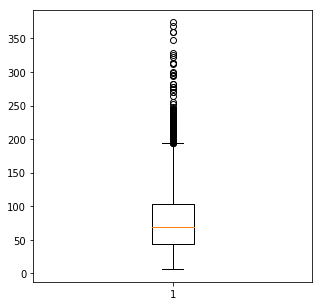

In [79]:
df['pre_clean_len'] = [len(t) for t in df.text]
fig, ax = plt.subplots(figsize=(5, 5))
plt.boxplot(df.pre_clean_len)
plt.show()

In [81]:
from bs4 import BeautifulSoup #remove html encoding '&amp','&quot'
import re #remove @mention
from nltk.tokenize import WordPunctTokenizer
tok = WordPunctTokenizer()
pat1 = r'@[A-Za-z0-9]+'
pat2 = r'https?://[A-Za-z0-9./]+'
combined_pat = r'|'.join((pat1, pat2))

def tweet_cleaner(text):
    soup = BeautifulSoup(text)
    souped = soup.get_text()
    stripped = re.sub(combined_pat, '', souped)
    try:
        clean = stripped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        clean = stripped
    letters_only = re.sub("[^a-zA-Z]", " ", clean)
    lower_case = letters_only.lower()
    words = tok.tokenize(lower_case)
    return (" ".join(words)).strip()

testing = df.text[:100]
test_result = []

for t in testing:
    test_result.append(tweet_cleaner(t))

print('The cleaning results:')
test_result[:10]

The cleaning results:


['awww that s a bummer you shoulda got david carr of third day to do it d',
 'is upset that he can t update his facebook by texting it and might cry as a result school today also blah',
 'i dived many times for the ball managed to save the rest go out of bounds',
 'my whole body feels itchy and like its on fire',
 'no it s not behaving at all i m mad why am i here because i can t see you all over there',
 'not the whole crew',
 'need a hug',
 'hey long time no see yes rains a bit only a bit lol i m fine thanks how s you',
 'k nope they didn t have it',
 'que me muera']

In [82]:
nums = [0,400000,800000,1200000,1600000]
print("Cleaning and parsing the tweets...\n")
clean_tweet_texts = []
for i in range(nums[0],nums[1]):
    if( (i+1)%10000 == 0 ):
        print("Tweets %d of %d has been processed" % (i+1, nums[1]), end="\r")                                                                
    clean_tweet_texts.append(tweet_cleaner(df['text'][i]))

Cleaning and parsing the tweets...



... and the same was done for the rest of the dataset, and saved into a file.

In [97]:
# Add clean_text to original data and convert to numerical data
training = '/home/hupham/sentiment_detection/clean_tweet.csv'
test = '/home/hupham/sentiment_detection/testdata.manual.2009.06.14.csv'

import csv
           
def parse_tweets_cleaned(filename):
    with open(filename, 'r',errors='ignore') as csvfile:
        reader = csv.reader(csvfile)
        for col in reader:
            assert len(col) == 7
            #print(int(col[0]),col[-1])
            yield (col[1]),col[-1]

def parse_tweets(filename):
    with open(filename, 'r',errors='ignore') as csvfile:
        reader = csv.reader(csvfile)
        for col in reader:
            assert len(col) == 6
            #print(int(col[0]),col[-1])
            yield (col[0]),col[-1]

In [108]:
tweets_train = [*parse_tweets_cleaned(training)]
tweets_test = [*parse_tweets(test)]
tweets_test = [tweet for tweet in tweets_test if tweet[0]!=2]

import random
random.shuffle(tweets_train)

tweets_train_texts = [text for label, text in tweets_train]
tweets_train_labels = [label for label, text in tweets_train]
tweets_train_labels = [-1 if label=='0' else 1 for label in tweets_train_labels]
tweets_test_texts = [text for label, text in tweets_test]
tweets_test_labels = [label for label, text in tweets_test]
tweets_test_labels = [-1 if label=='0' else 1 for label in tweets_test_labels]

In [110]:
space_tokenizer = lambda text: text.split()

# Featurization and vectorization
vectorizer = TfidfVectorizer(tokenizer=space_tokenizer, ngram_range=(1,2))

tweets_vectorizer = vectorizer.fit(tweets_train_texts)
tweets_train_X = tweets_vectorizer.transform(tweets_train_texts)
tweets_test_X = tweets_vectorizer.transform(tweets_test_texts)

tweets_classifier = LinearSVC(
    C=1.0,
    class_weight=None,
    max_iter=1000,
    loss='squared_hinge'
)

tweets_classifier.fit(tweets_train_X, tweets_train_labels)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [113]:
%%time

# prediction

tweets_pred_labels_cleaned = tweets_classifier.predict(tweets_test_X)

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 719 µs


In [115]:
# Evaluation and analysis
tweets_accuracy_cleaned = accuracy_score(tweets_test_labels, tweets_pred_labels_cleaned)

print('Twitter dataset (cleaned) accuracy {:.2%}'.format(tweets_accuracy_cleaned))

Twitter dataset (cleaned) accuracy 78.51%


In [117]:
print("Twitter dataset (cleanup) results")
print(classification_report(tweets_test_labels, tweets_pred_labels_cleaned))
print()

Twitter dataset (cleanup) results
             precision    recall  f1-score   support

         -1       0.68      0.73      0.71       177
          1       0.85      0.81      0.83       321

avg / total       0.79      0.79      0.79       498




In [123]:
from IPython.core.display import HTML

new_error = 1 - tweets_accuracy_cleaned
old_error = 1 - tweets_accuracy
relative_reduction_in_error = (old_error - new_error) / old_error

HTML('Relative reduction in error: {:.2%}'.format(relative_reduction_in_error))

The special characters were cleaned, however, it negatively affects the performance of the classifier. This is possibly due to the fact that emojis, which are important clues for classification, are also cleaned along the process. In addition, the '@' character may play a role in the classification as well.

In [125]:
show_weights(tweets_classifier, vec=tweets_vectorizer)

<h1>Milestone 2</h1><br>
Expand your previous results with a cross-domain study, in other words train on one dataset, and test on different dataset from a different domain. Report what happens to the results and draw conclusions about the transferability of trained sentiment classifiers across different domains.

In [47]:
# Use IMBD vectroizer on the twitter test data
tweets_test_X_cross = imdb_vectorizer.transform(tweets_test_texts)

# Use twitter vectroizer on the IMBD test data
imdb_test_X_cross = tweets_vectorizer.transform(imdb_test_texts)

# Predict - trained on one dataset, tested on the other
imdb_pred_labels_cross = imdb_classifier.predict(tweets_test_X_cross)
tweets_pred_labels_cross = tweets_classifier.predict(imdb_test_X_cross)

# Evaluation and analysis
imdb_accuracy_cross = accuracy_score(tweets_test_labels, imdb_pred_labels_cross) 
tweets_accuracy_cross = accuracy_score(imdb_test_labels, tweets_pred_labels_cross)

print('Test tweets, predict IMBD {:.2%}'.format(imdb_accuracy_cross))
print('Test IMBD, predict tweets {:.2%}'.format(tweets_accuracy_cross))

Test tweets, predict IMBD 68.52%
Test IMBD, predict tweets 72.92%


<h1>Milestone 3</h1>
<br>
A cool idea of how to build a sentiment analyzer for a target language that has no such tool, e.g. Finnish, would be to machine-translate some English training data to the language of interest and get a sentiment analyzer for free that way - if this idea works, that is. Pick a suitable English dataset and machine-translate it to Finnish or any other foreign language you know, using Google Translate or Bing Translate for example. You can either feed it via the web interfaces or create an account. For example Bing allows a 2M character free quota. Evaluate the resulting sentiment classifier qualitatively as well as quantitatively on a small sample of the target language sentences. You can sample texts from places like Reddit, online shop product reviews, movie reviews, online discussion fora, etc.

For this milestone, we use the python library <i>googletrans</i> to translate the IMDB dataset into Finnish. A classifier is trained on the translated dataset. This classifier is evaluated on our manually annotated dataset of Finnish movie reviews.

In [48]:
# How the library works

from googletrans import Translator

translator = Translator()
tr_object = translator.translate('I don\'t like to watch movies.', dest='fi')
print(tr_object.text)

En halua katsella elokuvia.


In [56]:
# Translate the English text to Finnish
# Challenge: Google translate allows a maximum character count of 5000 per query
#            And other challenges (we didn't bother to figure out what the problems were) 

%%time
imdb_train_translator = translator.translate(imdb_train_texts,src='en',dest='fi')
imdb_train_tekstit = [teksti.text for teksti in imdb_train_translator]

imdb_test_translator = translator.translate(imdb_test_texts,src='en',dest='fi')
imdb_test_tekstit = [teksti.text for teksti in imdb_test_translator]

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [ ]:
%%time
# Solution 2: Give a thousand bucks a.k.a. use a for loop

imdb_train = imdb_train_neg + imdb_train_pos
random.shuffle(imdb_train)
imdb_train_tekstit = []
imdb_train_leimat = []
for text,label in imdb_train:
    try:
        imdb_train_translator = translator.translate(text,src='en',dest='fi')
        imdb_train_tekstit.append(imdb_train_translator.text)
        imdb_train_leimat.append(label)
    except: # the thing doesn't recognize JSONDecodeError
        pass

print('Number of reviews we originally have (training set):',len(imdb_train))
print('Number of reviews left (training set):',len(imdb_train_tekstit))

Number of reviews we originally have (training set): 25000 <br>
Number of reviews left (training set): 21545 <br>
CPU times: user 3min 1s, sys: 4.89 s, total: 3min 5s <br>
Wall time: 2h 28min <br>

In [ ]:
# Another thousand bucks for the test set

imdb_test = imdb_test_neg + imdb_test_pos
imdb_test_tekstit = []
imdb_test_leimat = []
for text,label in imdb_test:
    try:
        imdb_test_translator = translator.translate(text,src='en',dest='fi')
        imdb_test_tekstit.append(imdb_test_translator.text)
        imdb_test_leimat.append(label)
    except: # the thing doesn't recognize JSONDecodeError
        pass

print('Number of reviews we originally have (test set):',len(imdb_test))
print('Number of reviews left (test set):',len(imdb_test_tekstit))

Number of reviews we originally have (test set): 25000<br>
Number of reviews left (test set): 22222<br>

In [ ]:
# save the translated text
import pickle
with open('imdb_fi.pickle','wb') as f:
    pickle.dump([imdb_train_tekstit,imdb_train_leimat,imdb_test_tekstit,imdb_test_leimat],f)

In [57]:
# load the traslated text
import pickle
[imdb_train_tekstit,imdb_train_leimat,imdb_test_tekstit,imdb_test_leimat] = pickle.load(open('imdb_fi.pickle','rb'))

Things we could have done:
<ul>
<li>fragment the long reviews</li>
<li>tune the TF-IDF hyperparameters</li>
</ul>

In [59]:
# sanity check
assert len(imdb_train_tekstit)==len(imdb_train_leimat)
assert len(imdb_test_tekstit)==len(imdb_test_leimat)

In [60]:
# Vectorizing

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from eli5 import show_weights

space_tokenizer = lambda text: text.split()


# Featurization and vectorization
vectorizer = TfidfVectorizer(tokenizer=space_tokenizer, ngram_range=(1,2))

imdb_vectorizer = vectorizer.fit(imdb_train_tekstit)
imdb_train_X = imdb_vectorizer.transform(imdb_train_tekstit)
#devel_X = vectorizer.transform(devel_texts)
imdb_test_X = imdb_vectorizer.transform(imdb_test_tekstit)

In [61]:
%%time

# Training SVM classifier

imdb_classifier = LinearSVC(
    C=1.0,
    class_weight=None,
    max_iter=1000,
    loss='squared_hinge'
)

imdb_classifier.fit(imdb_train_X, imdb_train_leimat)

CPU times: user 2.52 s, sys: 0 ns, total: 2.52 s
Wall time: 2.52 s


In [62]:
%%time

# Predict

imdb_pred_labels = imdb_classifier.predict(imdb_test_X)

CPU times: user 36 ms, sys: 0 ns, total: 36 ms
Wall time: 34.9 ms


In [63]:
# Results

# Evaluation and analysis
imdb_accuracy = accuracy_score(imdb_test_leimat, imdb_pred_labels)

print('IMDB accuracy {:.2%}'.format(imdb_accuracy))

print("IMDB dataset results")
print(classification_report(imdb_test_leimat, imdb_pred_labels))

show_weights(imdb_classifier, vec=imdb_vectorizer)

IMDB accuracy 87.42%
IMDB dataset results
             precision    recall  f1-score   support

         -1       0.88      0.86      0.87     11133
          1       0.87      0.89      0.88     11089

avg / total       0.87      0.87      0.87     22222



<h3>Evaluation on real Finnish data</h3>
<br>
Our self-annotated data consists of 24 (................description missing, leffatykki)

In [64]:
import csv

def parse_finnish_movie_reviews(filename):
    with open(filename, 'r') as csvfile:
        reader = csv.reader(csvfile,delimiter='|')
        for row in reader:
            assert len(row) == 2
            yield row[0],int(row[-1])

fi_dataset = [*parse_finnish_movie_reviews('/home/akeele/sentiment_detection/finnish_movie_reviews.txt')]
fi_tekstit = [text for text, label in fi_dataset]
fi_leimat = [label for text,label in fi_dataset]

In [65]:
# see the reviews
for t, l in zip(fi_tekstit[:3],fi_leimat[:3]):
    print(l)
    print(t)
    print('\n')

-1
Amatöörimäinen toimintapommi on kivulias kokemus kaksituntisena. Se olisi sitä jopa tunnin mittaisena. Tai lyhärinä.


-1
Elokuvan mainoslause on: Nyt huijataan koko rahan edestä. Totta, koko pääsylipun ja poppareiden hinnan edestä.


1
Vankilasta vapautuneesta naisesta kertova karhea draama osoittaa, ettei ihmisyyden synkälle puolelle rohkeasti katsovan Samppa Batalin Äpärä-esikoinen ollut onnen kantamoinen.




In [66]:
fi_tekstit_vectorized = imdb_vectorizer.transform(fi_tekstit)
fi_pred_labels = imdb_classifier.predict(fi_tekstit_vectorized)

In [67]:
fi_accuracy = accuracy_score(fi_leimat, fi_pred_labels)

print('Accuracy on the Finnish dataset {:.2%}'.format(fi_accuracy))

print("Finnish dataset results")
print(classification_report(fi_leimat, fi_pred_labels))

Accuracy on the Finnish dataset 83.33%
Finnish dataset results
             precision    recall  f1-score   support

         -1       0.88      0.70      0.78        10
          1       0.81      0.93      0.87        14

avg / total       0.84      0.83      0.83        24



In [68]:
for text, gold_standard, prediction in zip(fi_tekstit,fi_leimat, fi_pred_labels):
    if gold_standard!=prediction:
        print('Gold standard:',gold_standard)
        print('Text:',text)
        print('\n')

Gold standard: -1
Text: Vakooja, joka keitti teetä ja tarjoili keksejä.


Gold standard: -1
Text: Asghar Farhadi kohtaa Lost in Translationin. Kirjaimellisessa ja huonossa mielessä.


Gold standard: -1
Text: Ruotsalainen romanttinen draamakomedia kertoo vaivaannuttavan kankean tarinan viiden pariskunnan riutumisesta rakkauden ohdakkeisella tiellä.


Gold standard: 1
Text: Puhelin soi,teinejä kuolee, valkonaamainen murhaaja juoksentelee takapihalla puukko kädessä...Murhaaja on valinnut uhrinsa jo etukäteen. Vai onko? Kuka tietää... On olemassa surkeita kauhuelokuvia ja on olemassa hyviä kauhuelokuvia. Ongelmana on vain se että nykyään on liian paljon huonoja kauhuelokuvia. Mutta tämä! Scream on upea esimerkki harvinaisista hyvistä kauhuelokuvista. Nykyään kauhuelokuvaissa vain tapetaan ilman kunnon motiivia tai juonta. Mutta Screamissa on se kaikki! Kunnon motiivi ja (uskokaa tai älkää) upea juoni! Näyttelijät ansaitsisivat kylläkin Oscar-palkinnon. Varsinkin Neve Campbell. Hänen kiljum

Results after translation look promising. We didn't expect so good results because the quality of machine translation can vary. With our 24 manually picked Finnish movie reviews from leffatykki.com and episodi.fi the classifier could predict the label correctly on 20 out of 24 reviews. The misclassified reviews are either very short or they contain several conflicting words in terms of what is considered positive or negative by the classifier.